<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/01_crawl_av_pages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AV-crawl: Advanced Web Crawler with Filtering and Markdown Conversion

#### Web crawling: Crawls, filters URLs, and converts HTML to Markdown.


# Table of Contents

- [1. Introduction](#1-Introduction)
- [2. Requirements & Setup](#2-Requirements--Setup)
- [3. Crawler Configuration and Utility Functions](#3-Crawler-Configuration-and-Utility-Functions)
- [4. Web Crawler With Filtering](#4-Web-Crawler-With-Filtering)
- [5. Further Manual Filtering](#5-Further-Manual-Filtering)
- [6. Convert Crawled HTML to Markdown](#6-Convert-Crawled-HTML-to-Markdown)
- [7. Save and Inspect Results](#7-Save-and-Inspect-Results)

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

## 1. Introduction

This notebook showcases a practical web-crawling workflow:

- Crawl **internal** links from a starting URL (here: Analytics Vidhya’s DataHack Summit site)
- Filter crawled URLs based on inclusion/exclusion patterns or domains
- Convert raw HTML content into clean Markdown text for easier reading or exporting


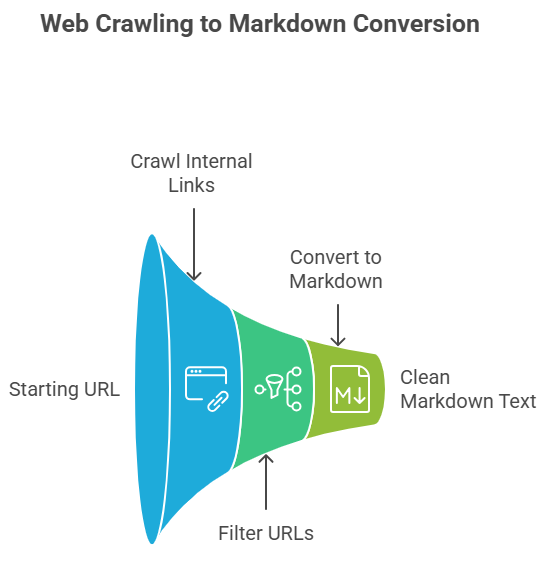

## 2. Requirements & Setup

First, install dependencies:
- `requests` and `beautifulsoup4` for crawling
- `markdownify` (easy, tested) or `html-to-markdown` (modern alternative) for HTML-to-Markdown



In [ ]:
!pip install r-r requirements.txt

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from collections import deque
import time
import warnings
import urllib3

# Optional: Try html-to-markdown if preferred (pip install html-to-markdown)
try:
    from markdownify import markdownify as md_convert
except ImportError:
    # fallback to html-to-markdown if installed
    try:
        from html_to_markdown import convert_to_markdown as md_convert
    except ImportError:
        md_convert = None

# Suppress warnings for notebook clarity
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings("ignore")


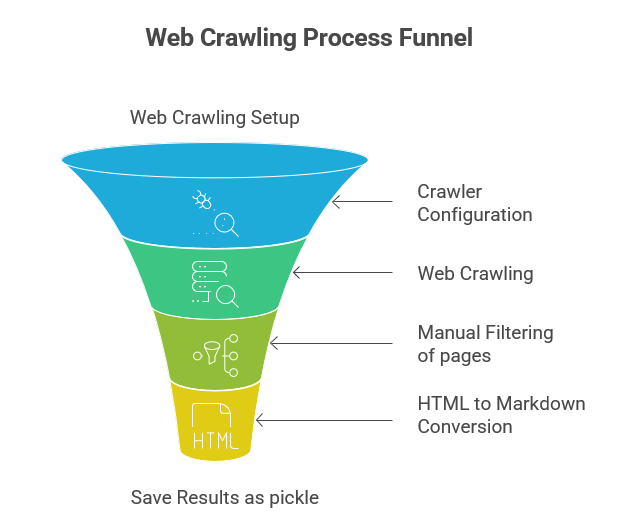

## 3. Crawler Configuration and Utility Functions

In [ ]:
START_URL = "https://www.analyticsvidhya.com/datahacksummit/"
BASE_DOMAIN = "www.analyticsvidhya.com"
MAX_PAGES = 100

visited = set()
queue = deque([START_URL])
output_urls = []
page_data = []  # List of dicts: {'url', 'content'}


In [ ]:
def is_valid_url(url):
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

def is_internal_url(url, base_domain=BASE_DOMAIN):
    return urlparse(url).netloc == base_domain

def url_passes_filters(url, include_patterns=None, exclude_patterns=None, domain_blocklist=None):
    """
    Returns True if the URL passes filtering rules (inclusion, exclusion, blocklist).
    Patterns: lists of strings (keywords, domain names, substrings, etc.)
    """
    parsed = urlparse(url)
    # Block specific domains
    if domain_blocklist:
        for dom in domain_blocklist:
            if dom in parsed.netloc:
                return False
    # Block by substring pattern
    if exclude_patterns:
        for p in exclude_patterns:
            if p in url:
                return False
    # Allow only certain substrings if include_patterns specified
    if include_patterns:
        for p in include_patterns:
            if p in url:
                return True
        return False
    return True  # if nothing triggered above


## 4. Web Crawler With Filtering

Demo shows filtering: blocklist of unwanted domains & substrings, and/or allowlist (include patterns).


In [ ]:
# Example: Block social or checkout domains, and allow only pages with 'datahack' in the path
DOMAIN_BLOCKLIST = ['facebook.com', 'linkedin.com', 'twitter.com', 'instagram.com', 'explara.com']
EXCLUDE_PATTERNS = ['privacy', 'policy', 'checkout', 'login']  # Exclusion substrings
INCLUDE_PATTERNS = None  # Example: ['datahack']

def crawl():
    pages_crawled = 0
    while queue and pages_crawled < MAX_PAGES:
        current_url = queue.popleft()
        if current_url in visited or not url_passes_filters(
            current_url, INCLUDE_PATTERNS, EXCLUDE_PATTERNS, DOMAIN_BLOCKLIST):
            continue
        visited.add(current_url)
        pages_crawled += 1
        print(f"[{pages_crawled}] Crawling: {current_url}")
        try:
            response = requests.get(current_url, timeout=8, verify=False)
            response.raise_for_status()
        except Exception as e:
            print(f"Failed: {e}")
            continue

        output_urls.append(current_url)
        page_data.append({'url': current_url, 'content': response.text})

        soup = BeautifulSoup(response.text, "html.parser")
        for a_tag in soup.find_all("a", href=True):
            href = a_tag["href"]
            full_url = urljoin(current_url, href)
            normalized_url = full_url.split("#")[0].rstrip("/")
            if (
                is_valid_url(normalized_url)
                and is_internal_url(normalized_url)
                and normalized_url not in visited
            ):
                if url_passes_filters(normalized_url, INCLUDE_PATTERNS, EXCLUDE_PATTERNS, DOMAIN_BLOCKLIST):
                    queue.append(normalized_url)
    print(f"\n✅ {len(output_urls)} pages crawled after filtering.")


In [ ]:
# Run the crawler
crawl()


[1] Crawling: https://www.analyticsvidhya.com/datahacksummit/
[2] Crawling: https://www.analyticsvidhya.com/datahacksummit
[3] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/awards
[4] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai
[5] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai
[6] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title
[7] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2
[8] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/generative-ai-for-business-leaders
[9] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentops-building-and-deploying-ai-agents
[10] Crawl

## 5. Further Manual Filtering

In [ ]:
remove_urls = ['https://www.analyticsvidhya.com/datahacksummit-2025/sessions/llmops-productionalizing-real-world-applications-with-llms-2',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/mastering-real-world-agentic-ai-applications-with-ag2-autogen',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/build-a-production-ready-multi-agent-application-with-crewai',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/from-theory-to-practice-training-llms-reinforcement-learning-and-ai',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/generative-ai-for-business-leaders',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentops-building-and-deploying-ai-agents',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/mastering-llms-training-fine-tuning-and-best-practices-2']

filtered_page_data = [
    entry for entry in page_data
    if entry['url'] == "https://www.analyticsvidhya.com/datahacksummit"
    or entry['url'].startswith("https://www.analyticsvidhya.com/datahacksummit-2025/")
]


filtered_page_data = [entry for entry in filtered_page_data if entry['url'] not in remove_urls]

print(f"\n✅ {len(filtered_page_data)} crawled pages selected after manual filtering.")



✅ 80 crawled pages selected after manual filtering.


## 6. Convert Crawled HTML to Markdown

Use **html2text** to transform page HTML to markdown for easier interpretation


In [ ]:
# Convert all HTML contents to markdown (if converter is available)
import html2text
from IPython.display import Markdown

def convert_html_to_markdown():
    """Creates and configures an html2text converter."""
    converter = html2text.HTML2Text()
    converter.ignore_links = False       # Set True if you want to remove links
    converter.ignore_images = True       # Set False if you want to include image URLs
    converter.body_width = 0             # Prevents line wrapping
    return converter

def extract_section(text, start_keyword=None, end_keywords=None):
    """
    Extracts text between a start keyword and one of several end keywords.

    Args:
        text: The input string.
        start_keyword: The keyword to start extraction after.
        end_keywords: A list of keywords to end extraction before.

    Returns:
        The extracted text, or the original text if keywords are not found.
    """
    if start_keyword:
        parts = text.split(start_keyword, maxsplit=1)
        text = parts[1].strip() if len(parts) > 1 else ""

    if end_keywords:
        for keyword in end_keywords:
            parts = text.split(keyword, maxsplit=1)
            text = parts[0].strip() if len(parts) > 1 else text.strip()
    return text

cleaned_page_content = []
converter = convert_html_to_markdown()

end_keywords = ["Participate", "Keynote", "Workshop Details", "Past Edition", "Download Brochure"]

for entry in filtered_page_data:
    markdown = converter.handle(entry["content"])
    cleaned_text = extract_section(markdown, start_keyword="Download Brochure", end_keywords=end_keywords)

    cleaned_page_content.append({
        "url": entry["url"],
        "content": cleaned_text
    })

## 7. Save and Inspect Results


In [ ]:
import pickle
# Save for reuse
with open("page_data.pkl", "wb") as f:
    pickle.dump(cleaned_page_content, f)

In [ ]:
# Quick summary: crawled URLs and markdown preview
print(f"Total pages: {len(cleaned_page_content)}")
print("--- Example URLs ---")
for page in cleaned_page_content[:5]:
    print(page['url'])

print("\n--- Markdown Snippet from First Page ---")
print(cleaned_page_content[0]['markdown'][:500] if cleaned_page_content and 'markdown' in cleaned_page_content[0] else cleaned_page_content[0]['content'][:500])


Total pages: 80
--- Example URLs ---
https://www.analyticsvidhya.com/datahacksummit
https://www.analyticsvidhya.com/datahacksummit-2025/awards
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title

--- Markdown Snippet from First Page ---
# The AI Trinity

## Powering the Future

### Generative | Agentic | Responsible

## India's Most Futuristic AI Conference

### August 20-23, 2025  • The Leela Bhartiya City Bengaluru 

Send WhatsApp Updates

Download Agenda

Your browser does not support the video tag. 

## 1200+

### Attendees

## 80+

### AI Talks

## 50+

### Hack Sessions

## 10+

### Workshops

## Hands-on AI Workshops

### [Mastering Intelligent Agents